In [1]:
'''

根据路路建议，看看音调之间能不能直接进行decoding。

而且我要考虑 随机组合，两个音调之间，三个音调，四个音调

'''


'\n\n根据路路建议，看看音调之间能不能直接进行decoding。\n\n而且我要考虑 随机组合，两个音调之间，三个音调，四个音调\n\n'

In [2]:
'''

根据路路建议，看看音调之间能不能直接进行decoding。

而且我要考虑 随机组合，两个音调之间，三个音调，四个音调

'''


'\n\n根据路路建议，看看音调之间能不能直接进行decoding。\n\n而且我要考虑 随机组合，两个音调之间，三个音调，四个音调\n\n'

In [1]:

import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
from neurora.decoding import tbyt_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc
from neurora.decoding import ct_decoding_kfold
from neurora.rsa_plot import plot_ct_decoding_acc
import matplotlib.pyplot as plt


In [2]:
list_epochs_all = list()

sub_ids = [

    "pre2001","pre2002","pre2003","pre2004","pre2005",

]
file_path = 'E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\\6epoch_clean_RSA\\'

for sub_id in sub_ids:
    data_path = file_path + sub_id + '_RSA-epo.fif'
    epochs_all = mne.read_epochs(fname=data_path)
    #做decoding要考虑被试内每个条件试次一样，如果被试间不一样可以用循环来解决。
    epochs_all.equalize_event_counts(method='mintime')
    list_epochs_all.append(epochs_all)

# 如果只想看某一部分的脑区,配合更改ndarray的维度
# channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
# epochs_nieye = epochs_all.pick(picks=channels_nieye)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''

Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_RSA\pre2001_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1733 matching events found
No baseline correction applied
0 projection items activated
Dropped 33 epochs: 0, 25, 515, 546, 553, 570, 571, 576, 581, 1055, 1083, 1120, 1127, 1138, 1151, 1154, 1156, 1247, 1258, 1260, 1341, 1365, 1368, 1372, 1389, 1447, 1466, 1486, 1600, 1670, 1672, 1698, 1725
Reading E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\data\6epoch_clean_RSA\pre2002_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1722 matching events found
No baseline correction applied
0 projection items activated
Dropped 42 epochs: 2, 8, 9, 23, 31, 38, 50, 58, 63, 116, 119, 165, 382, 444, 479, 486, 494, 503, 580, 623, 652, 657, 779, 820, 838, 940, 1145, 1163, 1632, 164

'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [3]:
'''
单独处理一下被试 pre2002，改一下channel属性
'''
chan_types_dict = { "VEOG":"eog","HEOG":"eog"}
list_epochs_all[1].set_channel_types(chan_types_dict)

Number of events,1680
Events,101: 84102: 84103: 84104: 84111: 84112: 84113: 84114: 84121: 84122: 84123: 84124: 84131: 84132: 84133: 84134: 84141: 84142: 84143: 84144: 84
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [4]:
'''
先整理单个的被试看看

data的结构要求： [n_subs, n_trials, n_chls, n_ts]
label的结构要求： [n_subs, n_trials]

'''

conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', '141', '142', '143', '144']


#初始值
subindex = 0
list_subdata = list()
list_sublabel = list()
for m in range(len(sub_ids)):
    #单个被试的数据
    epochs_forlen = list_epochs_all[m][conds[0]]
    # 每个被试的trial数量是不一样的
    # trial数不能放在第一位，第一位是condition
    num_trials = len(epochs_forlen.events[:,1])
    subdata = np.zeros([20, num_trials, 62,  1001], dtype=np.float32)
    sublabel = np.zeros([0,0])

    for i in range(len(conds)):
        epochs = list_epochs_all[m][conds[i]]
        #做decoding，这里就不能是平均了吧。
        # 这里get_data()还会把所有的channel都选上，你需要pick一下,只要eeg，不要眼动数据
        data = epochs.get_data(picks='eeg')
        label_cond = epochs.events[:,2]
        #每种条件的cond
        sublabel = np.append(sublabel,label_cond)
        sublabel = np.reshape(sublabel, [1,len(sublabel[:])])
        subdata[i] = data
        # 现在是[con, trial, chan, ts]
        # [n_cons, n_subs, n_trials, n_chls, n_ts]需要这样的结构
        # 需要中间插入一个subs
    subdata = np.reshape(subdata, [20, 1, num_trials, 62, 1001])
    # 在某个维度上面拉平
    # 把condition的维度乘到 trial上面？
    data_decode = np.reshape(subdata,[1, 20 * num_trials,  62, 1001])
    list_subdata.append(data_decode)
    list_sublabel.append(sublabel)

'''
对label进行处理，
让每个值都除以100，如果是辅音，那么就取商，如果是音调，那么就取余数。
'''


'\n对label进行处理，\n让每个值都除以100，如果是辅音，那么就取商，如果是音调，那么就取余数。\n'

In [70]:
# label_fuyin = ((sublabel-100)/10).astype(int)
# label_yindiao = ((sublabel-100)%10).astype(int)

# accs_fuyin = tbyt_decoding_kfold(data_decode,label_fuyin, n=5, time_win=50,time_step=5)
# accs_yindiao = tbyt_decoding_kfold(data_decode,label_yindiao, n=4, time_win=50,time_step=5)
# plt.plot(accs_fuyin[0,:])


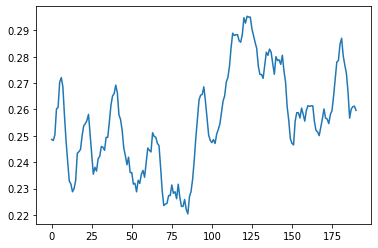

In [70]:

# plt.plot(accs_yindiao[0,:])

In [6]:
'''

每个被试trial数量不一致，所以只能循环求每个被试的accs再拼接

'''
n_subs = len(sub_ids)
n_ts = 1001
time_win = 50
time_step = 5
accs_fuyin_allsubs = np.zeros([n_subs, int((n_ts-time_win)/time_step)+1, int((n_ts-time_win)/time_step)+1])
accs_yindiao_allsubs = np.zeros([n_subs, int((n_ts-time_win)/time_step)+1, int((n_ts-time_win)/time_step)+1])
# 辅音
for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    # 区别在这里
    label_fuyin = ((label_original-100)/10).astype(int)
    accs_fuyin = ct_decoding_kfold(data_decode,label_fuyin, n=5, time_win=50,time_step=5, nfolds=3, nrepeats=10)
    accs_fuyin_allsubs[i] = accs_fuyin


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!




Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



D:\ProgramData\anaconda\envs\mne\lib\site-packages\neurora\rsa_plot.py:1050: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, np.transpose(newps, (1, 0)), [0, 1], colors="silver", alpha=0.9, linewidths=3,


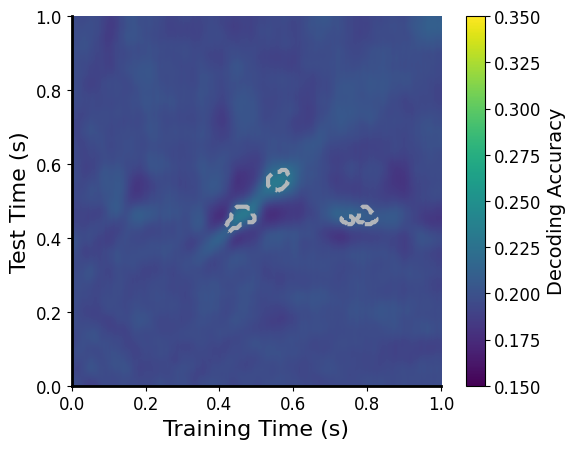

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
plot_ct_decoding_acc(accs_fuyin_allsubs, start_timex=0, end_timex=1,time_intervalx=0.005,
                     time_intervaly=0.005, chance=0.2, clim=[0.15,0.35], p=0.05)


In [11]:
# 辅音
for i in range(len(sub_ids)):
    data_decode = list_subdata[i]
    label_original = list_sublabel[i]
    # 区别在这里
    label_fuyin = ((label_original-100)/10).astype(int)
    accs_fuyin = tbyt_decoding_kfold(data_decode,label_fuyin, n=5, time_win=50,time_step=5, nfolds=5, nrepeats=20)
    accs_fuyin_allsubs[i] = accs_fuyin


Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!

Calculating: [====================================================================================================] 100.00%
Decoding finished!




Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
224ms to 250ms


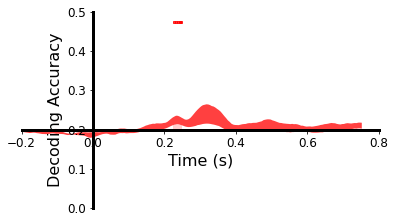

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [13]:
plot_tbyt_decoding_acc(accs_fuyin_allsubs, start_time=-0.2, end_time=0.755, time_interval=0.005, chance=0.2, color='red', ylim=[0,0.5],xlim=[-0.2,0.8])


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
330ms to 514ms
575ms to 630ms
710ms to 1000ms


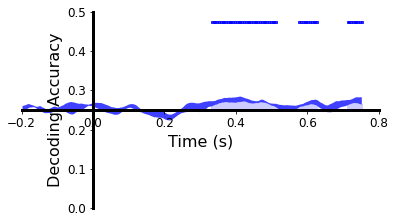

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [92]:
%matplotlib inline
